In [1]:
# import
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from nctpy.utils import matrix_normalization
from nctpy.energies import get_control_inputs, integrate_u
from nctpy.energies import minimum_energy_fast
from nctpy.utils import expand_states
from nctpy.plotting import set_plotting_params, reg_plot
set_plotting_params()

In [2]:
# load data
projdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/nctpy'
A = np.load(os.path.join(projdir, 'data', 'pnc_schaefer200_Am.npy'))

In [3]:
print(A.shape)

(200, 200)


## Energy settings

In [4]:
# setup states
n_nodes = A.shape[0]
n_states = int(n_nodes/10)
state_size = int(n_nodes/n_states)

states = np.array([])
for i in np.arange(n_states):
    states = np.append(states, np.ones(state_size) * i)
states = states.astype(int)

In [5]:
print(states)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]


## Minimum energy

In [6]:
# settings
# time horizon
T = 1
# set all nodes as control nodes
B = np.eye(n_nodes)
# normalize A matrix for a continuous-time system
system = 'continuous'
A_norm = matrix_normalization(A, system=system)

In [7]:
start_time = time.time()  # start timer

# settings for minimum control energy
S = np.zeros((n_nodes, n_nodes))  # x is not constrained
xr = 'zero'  # x and u constrained toward zero activity

e = np.zeros((n_states, n_states))
for i in tqdm(np.arange(n_states)):
    x0 = states == i  # get ith initial state
    for j in np.arange(n_states):
        xf = states == j  # get jth target state
        x, u, n_err = get_control_inputs(A_norm=A_norm, T=T, B=B, x0=x0, xf=xf, system=system, xr=xr, S=S,
                                         expm_version='eig')  # get control inputs using minimum control
        e[i, j] = np.sum(integrate_u(u))

e = e / 1000  # divide e by 1000 to account for dt=0.001 in get_control_inputs

end_time = time.time()  # stop timer
elapsed_time = end_time - start_time
print('time elapsed in seconds: {:.2f}'.format(elapsed_time))  # print elapsed time

100%|██████████| 20/20 [01:35<00:00,  4.78s/it]

time elapsed in seconds: 95.68


## Minimum energy fast

In [8]:
x0_mat, xf_mat = expand_states(states)
print(x0_mat.shape, xf_mat.shape)

(200, 400) (200, 400)


In [9]:
start_time = time.time()  # start timer

e_fast = minimum_energy_fast(A_norm=A_norm, T=T, B=B, x0=x0_mat, xf=xf_mat)
e_fast = e_fast.transpose().reshape(n_states, n_states, n_nodes)
e_fast = np.sum(e_fast, axis=2)  # sum over nodes

end_time = time.time()  # stop timer
elapsed_time = end_time - start_time
print('time elapsed in seconds: {:.2f}'.format(elapsed_time)) # print elapsed time

time elapsed in seconds: 0.29


In [10]:
print(e.shape)
print(e_fast.shape)

(20, 20)
(20, 20)


In [11]:
print(np.max(e - e_fast))

2.7267077484793845e-11


### Plots

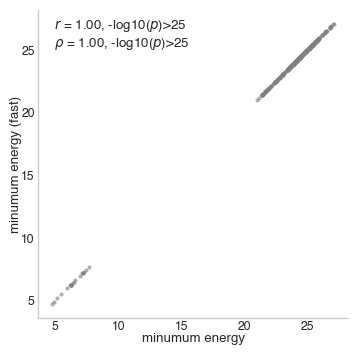

In [12]:
# plot
f, ax = plt.subplots(1, 1, figsize=(4, 4))

# correlation between whole-brain energy across state transitions
reg_plot(x=e.flatten(), y=e_fast.flatten(), xlabel='minumum energy', ylabel='minumum energy (fast)',
         ax=ax, add_spearman=True, kdeplot=False, regplot=False)
plt.show()
f.savefig('minimum_energy_fast', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.close()